# Statistiques sur les données de Finlande

In [1]:
import geopandas as gpd
import pandas as pd
# Lire le fichier Shapefile
gdf = gpd.read_file("../my-home-is-my-secret/my-home-is-my-secret-master/input/synthetic_trajectories_hel.shp")

# Afficher les 5 premières lignes
print(gdf.head())

# Vérifier le système de coordonnées (CRS)
print(gdf.crs)

# Vérifier le nombre de lignes
print(f"Nombre d'entités : {len(gdf)}")

   id                                           geometry
0   0  LINESTRING (374804.167 6671309.111, 374804.167...
1   1  LINESTRING (381446.167 6680889.111, 381449.702...
2   2  LINESTRING (378548.167 6677519.111, 378550.167...
3   3  LINESTRING (394400.167 6675473.111, 394402.288...
4   4  LINESTRING (385934.167 6675121.111, 385932.028...
EPSG:5048
Nombre d'entités : 10927


In [3]:
from shapely.ops import transform

def round_coordinates(geom, precision=6):
    return transform(lambda x, y: (round(x, precision), round(y, precision)), geom)

trajectory = gpd.read_file("../my-home-is-my-secret/my-home-is-my-secret-master/input/synthetic_trajectories_hel.shp")

print(trajectory.head())

# Vérifier le nombre de lignes
print(f"Nombre d'entités : {len(trajectory)}")

truncated = gpd.read_file("../my-home-is-my-secret/my-home-is-my-secret-master/output/truncated.shp")

print(truncated.head())

# Vérifier le nombre de lignes
print(f"Nombre d'entités : {len(truncated)}")

# Arrondir les géométries
truncated['geometry'] = truncated['geometry'].apply(round_coordinates)
trajectory['geometry'] = trajectory['geometry'].apply(round_coordinates)

   id                                           geometry
0   0  LINESTRING (374804.167 6671309.111, 374804.167...
1   1  LINESTRING (381446.167 6680889.111, 381449.702...
2   2  LINESTRING (378548.167 6677519.111, 378550.167...
3   3  LINESTRING (394400.167 6675473.111, 394402.288...
4   4  LINESTRING (385934.167 6675121.111, 385932.028...
Nombre d'entités : 10927
                                            geometry
0  LINESTRING (386635.516 6674030.45, 386640.469 ...
1  LINESTRING (382599.496 6670319.183, 382598.664...
2  LINESTRING (390747.976 6687251.956, 390750.693...
3  LINESTRING (390472.329 6679370.028, 390473.404...
4  LINESTRING (383254.345 6678340.042, 383250.475...
Nombre d'entités : 10921


In [4]:
# Trouver la correspondance pour chaque trajectoire tronquée
matches = []
for truncated_index, truncated_row in truncated.iterrows():
    truncated_geom = truncated_row['geometry']
    best_match_id = None
    
    # Comparer avec toutes les trajectoires originales
    for _, original_row in trajectory.iterrows():
        original_geom = original_row['geometry']
        
        # Vérifier si la trajectoire tronquée est contenue dans l'originale
        if original_geom.contains(truncated_geom):
            best_match_id = original_row['id']
            break  # Sortir de la boucle dès qu'une correspondance est trouvée
    
    # Ajouter la correspondance à la liste
    matches.append((truncated_index, best_match_id))

# Créer un DataFrame pour les correspondances
matches_df = pd.DataFrame(matches, columns=['truncated_index', 'original_id'])

# Afficher les correspondances
print(matches_df.head())

   truncated_index  original_id
0                0      11108.0
1                1      11107.0
2                2      11106.0
3                3      11105.0
4                4      11104.0


In [6]:
match_trajectory = []

for match_index, match_row in matches_df.iterrows():
    truncated_index = match_row['truncated_index']
    original_index = match_row['original_id']
    
    # Gérer les valeurs NaN dans original_index
    if pd.isna(original_index):  # Si original_index est NaN
        print(f"Avertissement : original_id est NaN pour la ligne {match_index}")
        continue  # Passer à l'itération suivante
    
    # Convertir original_index en entier
    original_index = int(original_index)
    
    # Vérifier si original_index existe dans trajectory
    matching_rows = trajectory.loc[trajectory['id'] == original_index, 'geometry']
    
    if not matching_rows.empty:  # S'il y a une correspondance
        path = matching_rows.values[0]  # Récupérer la première géométrie correspondante
    else:
        print(f"Avertissement : Aucune correspondance trouvée pour original_id = {original_index}")
        continue  # Passer à l'itération suivante
    
    # Convertir truncated_index en entier et récupérer la trajectoire tronquée
    try:
        path_truncated = truncated.iloc[int(truncated_index)].values[0]
    except (IndexError, ValueError) as e:
        print(f"Avertissement : Erreur avec truncated_index {truncated_index} : {e}")
        continue  # Passer à l'itération suivante
    
    # Ajouter à la liste
    match_trajectory.append((original_index, truncated_index, path, path_truncated))

# Créer un DataFrame avec les résultats
trajectory_and_truncated = pd.DataFrame(match_trajectory, columns=['original_id', 'truncated_index', 'original_trajectory', 'truncated_trajectory'])

# Afficher le DataFrame résultant
print(trajectory_and_truncated.head())

Avertissement : original_id est NaN pour la ligne 30
Avertissement : original_id est NaN pour la ligne 50
Avertissement : original_id est NaN pour la ligne 81
Avertissement : original_id est NaN pour la ligne 82
Avertissement : original_id est NaN pour la ligne 87
Avertissement : original_id est NaN pour la ligne 131
Avertissement : original_id est NaN pour la ligne 133
Avertissement : original_id est NaN pour la ligne 139
Avertissement : original_id est NaN pour la ligne 160
Avertissement : original_id est NaN pour la ligne 178
Avertissement : original_id est NaN pour la ligne 193
Avertissement : original_id est NaN pour la ligne 201
Avertissement : original_id est NaN pour la ligne 224
Avertissement : original_id est NaN pour la ligne 244
Avertissement : original_id est NaN pour la ligne 257
Avertissement : original_id est NaN pour la ligne 276
Avertissement : original_id est NaN pour la ligne 279
Avertissement : original_id est NaN pour la ligne 301
Avertissement : original_id est N

In [7]:
trajectory_and_truncated.to_csv('1000_test.csv', index=False, encoding='utf-8')

In [8]:
#Calcul des trajectoires supprimées
removed_trajectory = len(trajectory) - len(truncated)
print(f"Nombre de trajectoires supprimées : {removed_trajectory}")



Nombre de trajectoires supprimées : 6


In [12]:
from shapely import wkt
from shapely.geometry import LineString

# Fonction pour compter les points dans une géométrie Shapely
def count_points(geom):
    if geom is None or pd.isna(geom):  # Gérer les valeurs None ou NaN
        return 0
    if isinstance(geom, LineString):  # Vérifier si c'est un LineString
        return len(geom.coords)  # Retourner le nombre de points
    return 0  # Retourner 0 pour les autres types de géométries

trajectory_and_truncated['trajectory_count'] = trajectory_and_truncated['original_trajectory'].apply(count_points)
trajectory_and_truncated['truncated_count'] = trajectory_and_truncated['truncated_trajectory'].apply(count_points)

# Filtrer pour exclure les lignes où 'truncated_trajectory' est None
valid_trajectories = trajectory_and_truncated.dropna(subset=['original_trajectory'])


# Calculer le nombre total de points enlevés
valid_trajectories['points_removed'] = valid_trajectories['trajectory_count'] - valid_trajectories['truncated_count']
total_points_removed = valid_trajectories['points_removed'].sum()

print(f"Nombre total de points enlevés : {total_points_removed}")

# Nombre moyen de points enlevés par trajectoire
average_points_removed = valid_trajectories['points_removed'].mean()
print(f"Nombre moyen de points enlevés par trajectoire : {average_points_removed:.2f}")

#Nombre moyen de points par trajectoire
print(f"Nombre moyen de points par trajectoire : {trajectory_and_truncated['trajectory_count'].mean():.2f}")
print(f"Nombre moyen de points par trajectoire tronquée: {trajectory_and_truncated['truncated_count'].mean():.2f}")


Nombre total de points enlevés : 755549
Nombre moyen de points enlevés par trajectoire : 74.31
Nombre moyen de points par trajectoire : 2770.87
Nombre moyen de points par trajectoire tronquée: 2696.56


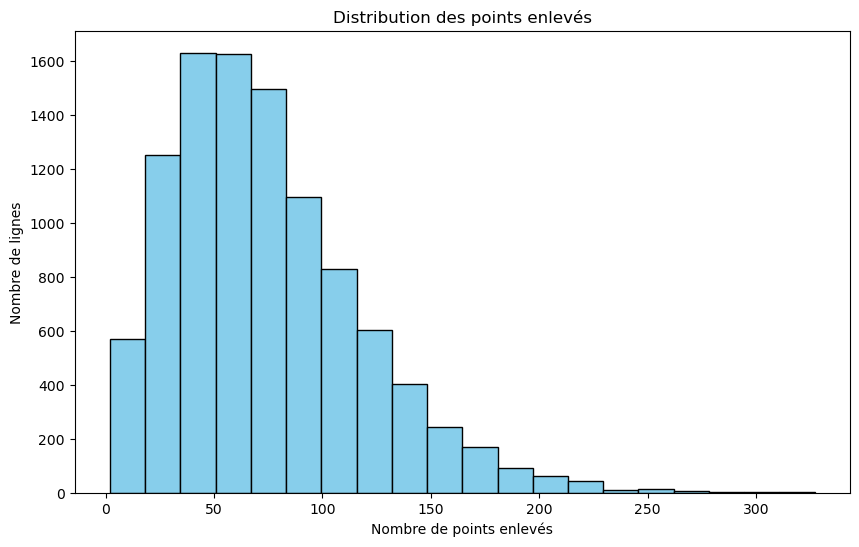

In [10]:
import matplotlib.pyplot as plt

# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = valid_trajectories['points_removed'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(valid_trajectories['points_removed'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points enlevés')
plt.show()

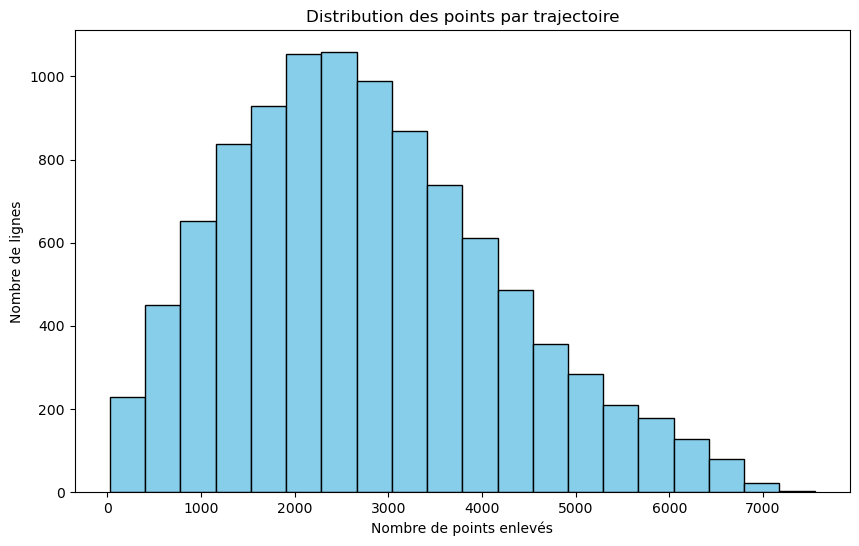

In [13]:
# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = trajectory_and_truncated['trajectory_count'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(trajectory_and_truncated['trajectory_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points par trajectoire')
plt.show()

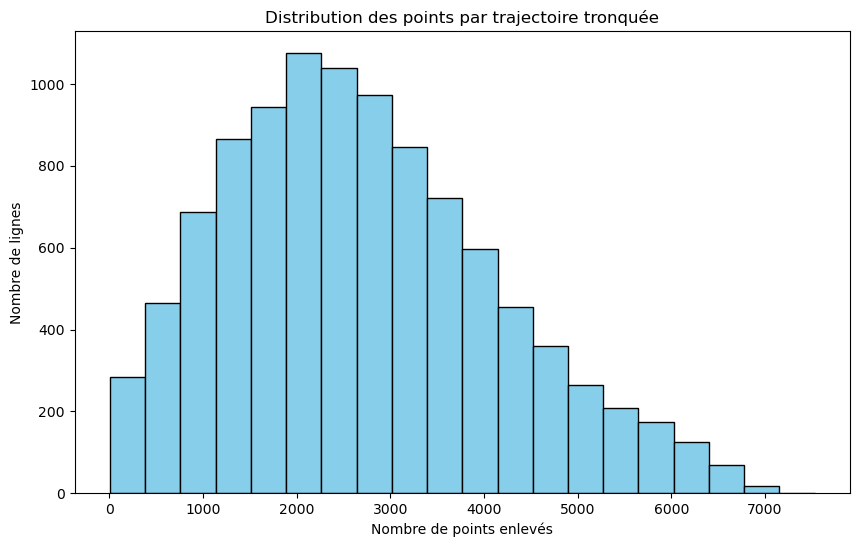

In [14]:
# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = trajectory_and_truncated['truncated_count'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(trajectory_and_truncated['truncated_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points par trajectoire tronquée')
plt.show()

le taux de réduction moyenne : 4.26


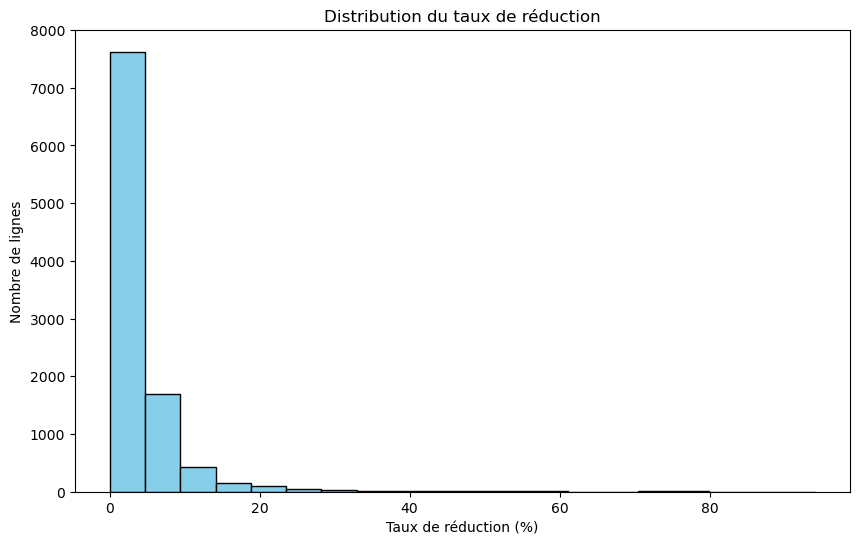

In [11]:
# Calculer le taux de réduction
valid_trajectories['reduction_rate'] = valid_trajectories['points_removed'] / valid_trajectories['trajectory_count'] * 100

# Statistiques descriptives pour le taux de réduction
print(f"le taux de réduction moyenne : {valid_trajectories['reduction_rate'].mean():.2f}")

# Histogramme du taux de réduction
plt.figure(figsize=(10, 6))
plt.hist(valid_trajectories['reduction_rate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Taux de réduction (%)')
plt.ylabel('Nombre de lignes')
plt.title('Distribution du taux de réduction')
plt.show()